In [1]:
import sys
sys.path.append('./src')

In [2]:
from retrieval_system.likelihood import LikelihoodRetrieval
from retrieval_system.clustering import ClusterBasedRetrieval
from retrieval_system.lda import LdaRetrieval

from evaluation.metrics import calculate_average_precision

In [3]:
import re
import string
import gc
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

gc.enable()

In [4]:
import ir_datasets
dataset = ir_datasets.load("beir/scidocs")

In [5]:
docs_df = pd.DataFrame(columns=['text', 'docno'])
docs_data = []

for doc in dataset.docs_iter():
    docs_data.append({'text': doc.text, 'docno': doc.doc_id})

docs_df = pd.concat([docs_df, pd.DataFrame(docs_data)], ignore_index=True)

In [6]:
queries_df = pd.DataFrame(columns=['query', 'qid'])
queries_data = []

for query in dataset.queries_iter():
    queries_data.append({'query': query.text, 'qid': query.query_id})

queries_df = pd.concat([queries_df, pd.DataFrame(queries_data)], ignore_index=True)

In [7]:
qrels_df = pd.DataFrame(columns=['docno', 'qid', 'label'])
qrels_data = []

for qrel in dataset.qrels_iter():
    qrels_data.append({'docno': qrel.doc_id, 'qid': qrel.query_id, 'label': qrel.relevance})

qrels_df = pd.concat([qrels_df, pd.DataFrame(qrels_data)], ignore_index=True)
qrels_df = qrels_df[qrels_df["label"] != 0]

In [8]:
doc_ids = np.unique(docs_df["docno"])
querie_ids = np.unique(queries_df["qid"])

encoder = LabelEncoder()
encoder.fit(doc_ids)

docs_df["docno"] = encoder.transform(docs_df["docno"])
qrels_df["docno"] =  encoder.transform(qrels_df["docno"])

encoder = LabelEncoder()
encoder.fit(querie_ids)

queries_df["qid"] = encoder.transform(queries_df["qid"])
qrels_df["qid"] =  encoder.transform(qrels_df["qid"])

In [9]:
docs_df["docno"]

0        11706
1        15445
2         5010
3         9626
4         9725
         ...  
25652    16845
25653    10603
25654    15466
25655     5027
25656    23073
Name: docno, Length: 25657, dtype: int64

In [10]:
docs_df.head()

,text,docno
0,An evolutionary recurrent network which automa...,11706
1,Dynamic economic dispatch (DED) is one of the ...,15445
2,It's not surprisingly when entering this site ...,5010
3,"In this paper, we introduce a new parameter, c...",9626
4,This paper proposes a recurrent fuzzy neural n...,9725


In [11]:
queries_df.head()

,query,qid
0,A Direct Search Method to solve Economic Dispa...,523
1,Bearish-Bullish Sentiment Analysis on Financia...,554
2,Predicting defects in SAP Java code: An experi...,617
3,Active-Metric Learning for Classification of R...,262
4,Ad Hoc Retrieval Experiments Using WordNet and...,29


In [12]:
qrels_df.head()

,docno,qid,label
0,11706,523,1
1,15445,523,1
2,5010,523,1
3,9626,523,1
4,9725,523,1


## Réduire la taille des données : 

### 1. Sample N docs : 

In [13]:
N_docs = 200
indices = np.arange(len(docs_df))
np.random.shuffle(indices)

docs_df_reduce = docs_df.iloc[indices[0:N_docs]].reset_index(drop=True)
doc_ids = np.unique(docs_df_reduce["docno"])
doc_ids.shape

(10,)

Mettre à jour le qrel avec les nouveaux doc retenus : 

In [14]:
qrels_df_1 = qrels_df[qrels_df["docno"].isin(doc_ids)]
query_ids = np.unique(qrels_df_1["qid"])
query_ids.shape

(1,)

Mettre à jour les queries avec celles qui existent dans qrels : 

In [15]:
queries_df_1 = queries_df[queries_df["qid"].isin(query_ids)]
queries_df_1.shape

(1, 2)

### 2. Sample N queries : 

In [16]:
N_queries = 50
indices = np.arange(len(queries_df_1))
queries_df_reduce = queries_df_1.iloc[indices[0:N_queries]].reset_index(drop=True)
query_ids = np.unique(queries_df_reduce["qid"])
query_ids.shape

(1,)

Mettre à jour le qrel avec les nouvelles query retenues : 

In [17]:
qrels_df_2 = qrels_df_1[qrels_df_1["qid"].isin(query_ids)]
qrels_df_2.shape

(1, 3)

### 3. Mettre à jour les df :

In [18]:
docs_df_new = docs_df_reduce
queries_df_new = queries_df_reduce
qrels_df_new = qrels_df_2

In [19]:
docs_df_new.shape, queries_df_new.shape, qrels_df_new.shape

((10, 2), (1, 2), (1, 3))

### 4. Re-coder les id :

In [20]:
doc_ids = np.unique(docs_df_new["docno"])
querie_ids = np.unique(queries_df_new["qid"])

encoder = LabelEncoder()
encoder.fit(doc_ids)

docs_df_new["docno"] = encoder.transform(docs_df_new["docno"])
qrels_df_new["docno"] =  encoder.transform(qrels_df_new["docno"])

encoder = LabelEncoder()
encoder.fit(querie_ids)

queries_df_new["qid"] = encoder.transform(queries_df_new["qid"])
qrels_df_new["qid"] =  encoder.transform(qrels_df_new["qid"])

In [21]:
Nds = docs_df_new["text"].map(lambda t: re.sub('[' + re.escape(string.punctuation) + ']', ' ', t).split(" ")).map(lambda l : list(filter(("").__ne__, l))).map(len)
Nds

0    146
1      0
2    143
3    110
4    113
5    112
6    121
7    120
8     54
9     85
Name: text, dtype: int64

In [22]:
true_relevance = np.zeros((len(queries_df_new), len(docs_df_new)))

for _, row in qrels_df_new.iterrows():
    qid = row['qid']
    docno = row['docno']
    
    if row["label"] != 0:
        true_relevance[int(qid), int(docno)] = 1

In [23]:
for i in range(len(queries_df_new)):
    a = np.random.rand() / 5
    indices = np.random.choice(len(docs_df_new), int(len(docs_df_new) * a), replace=False)
    true_relevance[i, indices] = 1

In [24]:
true_relevance.shape

(1, 10)

In [25]:
true_relevance[qrels_df_new["qid"].iloc[0], qrels_df_new["docno"].iloc[0]]

1.0

In [26]:
qrels_df_new

,docno,qid,label
541,7,0,1


In [27]:
sw = stopwords.words('english')

In [28]:
vectorizer = CountVectorizer(stop_words=sw, max_features=5000)
vectors = vectorizer.fit_transform(docs_df_new["text"])
queries = vectorizer.transform(queries_df_new["query"])

In [29]:
vectors.shape, queries.shape

((10, 440), (1, 440))

In [30]:
p_vectors = np.asarray(vectors.toarray())
p_vec_sum = p_vectors.sum(axis=1)[:, np.newaxis]
p_vectors = p_vectors / np.where(p_vec_sum == 0, 1., p_vec_sum)
vectors = p_vectors

In [31]:
p_queries = np.asarray(queries.toarray())
p_quer_sum = p_queries.sum(axis=1)[:, np.newaxis]
p_queries = p_queries / np.where(p_quer_sum == 0, 1., p_quer_sum)
queries = p_queries

In [32]:
gc.collect()

2

## Varier MC:

In [34]:
mc_lda_ap = []

for mc in range(1, 11):
    lda = LdaRetrieval(n_topics=400, mu=1000, alpha=None, beta=0.01, n_iter=30, nb_mc=mc, lmbda=0.7)
    lda.fit(vectors, Nds=Nds)
    
    lda_pred = lda.predict(queries)
    mc_lda_ap.append(calculate_average_precision(true_relevance, np.array([lda_pred]), models_names=["QL"], return_df=False))
    gc.collect()

Markov chain N° 10: 100%|██████████| 30/30 [00:01<00:00, 18.45it/s]


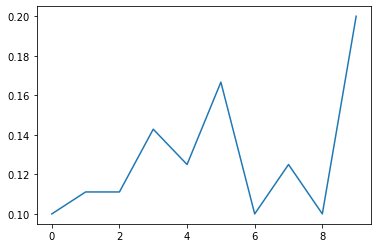

In [35]:
plt.plot(mc_lda_ap)